In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth

# Customer Personality Analysis Dataset

Load dataset

In [2]:
df = pd.read_csv("./marketing_campaign.csv",delimiter="\t")
df.head()
df.drop(columns=["ID"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year_Birth           2240 non-null   int64  
 1   Education            2240 non-null   object 
 2   Marital_Status       2240 non-null   object 
 3   Income               2216 non-null   float64
 4   Kidhome              2240 non-null   int64  
 5   Teenhome             2240 non-null   int64  
 6   Dt_Customer          2240 non-null   object 
 7   Recency              2240 non-null   int64  
 8   MntWines             2240 non-null   int64  
 9   MntFruits            2240 non-null   int64  
 10  MntMeatProducts      2240 non-null   int64  
 11  MntFishProducts      2240 non-null   int64  
 12  MntSweetProducts     2240 non-null   int64  
 13  MntGoldProds         2240 non-null   int64  
 14  NumDealsPurchases    2240 non-null   int64  
 15  NumWebPurchases      2240 non-null   i

The dataset has $2058$ fields. We have some missing values for the attribute "Income". We can keep them. We only remove when we consider the attribute income in our analysis.

In [3]:
df.dropna(inplace=True)

## Attributes

There are 29 attributes, we can divide them into 4 macro-categories: 
* People

    * ID: Customer's unique identifier
    * Year_Birth: Customer's birth year
    * Education: Customer's education level
    * Marital_Status: Customer's marital status
    * Income: Customer's yearly household income
    * Kidhome: Number of children in customer's household
    * Teenhome: Number of teenagers in customer's household
    * Dt_Customer: Date of customer's enrollment with the company
    * Recency: Number of days since customer's last purchase
    * Complain: 1 if customer complained in the last 2 years, 0 otherwise

* Products

    * MntWines: Amount spent on wine in last 2 years
    * MntFruits: Amount spent on fruits in last 2 years
    * MntMeatProducts: Amount spent on meat in last 2 years
    * MntFishProducts: Amount spent on fish in last 2 years
    * MntSweetProducts: Amount spent on sweets in last 2 years
    * MntGoldProds: Amount spent on gold in last 2 years

* Promotion

    * NumDealsPurchases: Number of purchases made with a discount
    * AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
    * AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
    * AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
    * AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
    * AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
    * Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

* Place

    * NumWebPurchases: Number of purchases made through the company’s web site
    * NumCatalogPurchases: Number of purchases made using a catalogue
    * NumStorePurchases: Number of purchases made directly in stores
    * NumWebVisitsMonth: Number of visits to company’s web site in the last month

In [4]:
#removing duplicates
df.drop_duplicates(inplace=True)

In [5]:
education = np.apply_along_axis(lambda x : "Education_"+x, axis=0, arr=df["Education"].unique())
marital_status = np.apply_along_axis(lambda x : "Marital_Status_"+x, axis=0, arr=df["Marital_Status"].unique())

In [6]:
#removing column year of birth and creating a column age ( age of each person in the moment he/she enroll)
df["age"] = (df["Dt_Customer"].apply(lambda x : x.split("-")[2]).astype(int)).to_numpy()-df["Year_Birth"].to_numpy()
df.drop(columns=["Year_Birth", "Dt_Customer"], inplace=True)

## Exploring data (people)

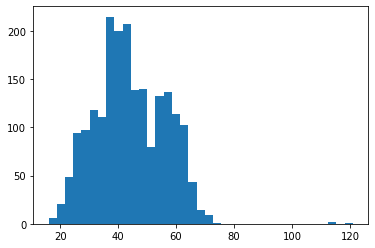

In [7]:
import matplotlib.pyplot as plt
plt.hist(df['age'],bins="auto");

There are two outliers: they are probably data entry errors (human errors while collecting data). We remove them.

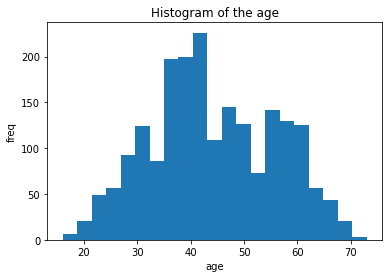

In [8]:
mask = df['age'] < 90
df = df[mask]
plt.hist(df['age'],bins="auto");
# plt.grid()
plt.xlabel("age")
plt.ylabel("freq");
plt.savefig("age.pdf")
plt.title("Histogram of the age");

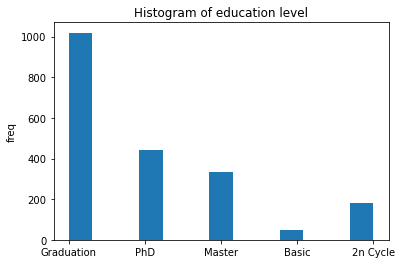

In [9]:
plt.hist(df['Education'],bins="auto");
plt.ylabel("freq")
plt.savefig("education.pdf")
plt.title("Histogram of education level");

We can combine features with the same meaning

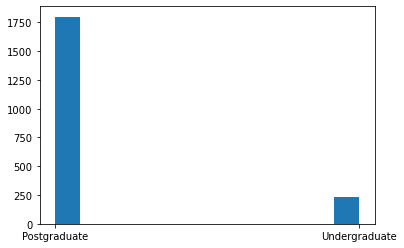

In [10]:
df['Education']=df['Education'].replace({'Basic':'Undergraduate','2n Cycle':'Undergraduate','Graduation':'Postgraduate','Master':'Postgraduate','PhD':'Postgraduate'})
plt.hist(df['Education'],bins="auto");

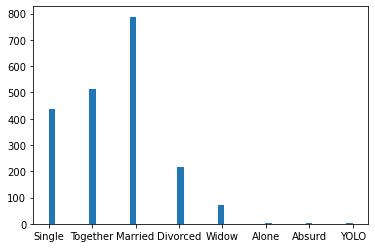

In [11]:
plt.hist(df['Marital_Status'],bins="auto");

From the histogram we can see strange values such as 'Alone', 'Absurd', 'YOLO', we assume that are human errors and we can remove them without affecting our analysis.

In [12]:
alone = df['Marital_Status'] == 'Alone'
df = df[~alone]
absurd = df['Marital_Status'] == 'Absurd'
df = df[~absurd]
yolo =  df['Marital_Status'] == 'YOLO'
df = df[~yolo]

Since the the features together and married have almost the same meaning we can combined them into a unique features, the same for single, divorced and widow.

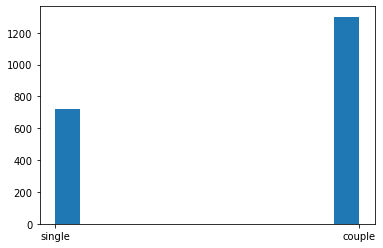

In [13]:
""" 

Together and Married -> Couple
Single, Divorced and Widow -> Single

"""

df["Marital_Status"].replace(to_replace=["Together","Married"], value = "couple",inplace=True)
df["Marital_Status"].replace(to_replace=["Single","Divorced","Widow"], value = "single",inplace=True)

plt.hist(df['Marital_Status'],bins="auto");

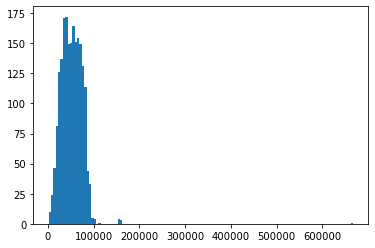

In [14]:
plt.hist(df['Income'],bins="auto");

There's one value with income = 666666, since it's an outlier and many algorithms are sensitive to outliers we remove it.

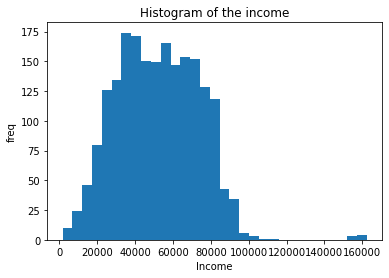

In [15]:
income = df['Income'] > 200000
df = df[~income]
plt.hist(df['Income'],bins="auto")
# plt.grid()
plt.xlabel("Income")
plt.ylabel("freq");
plt.savefig("income.pdf")
plt.title("Histogram of the income");

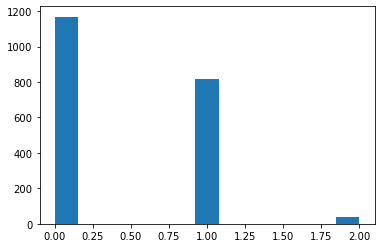

In [16]:
plt.hist(df['Kidhome'],bins="auto");

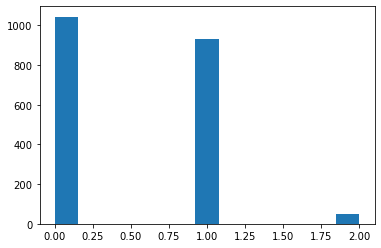

In [17]:
plt.hist(df['Teenhome'],bins="auto");

Since kidhome and teenhome have the same meanings we can combine them into a unique features

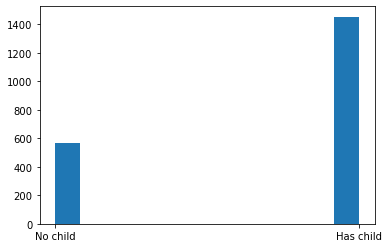

In [18]:
df['Children']=df['Kidhome']+df['Teenhome']
df['Has_child'] = np.where(df.Children> 0, 'Has child', 'No child')
plt.hist(df["Has_child"],bins="auto");

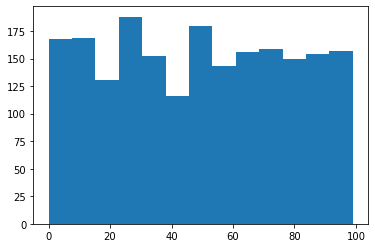

In [19]:
plt.hist(df['Recency'],bins="auto");

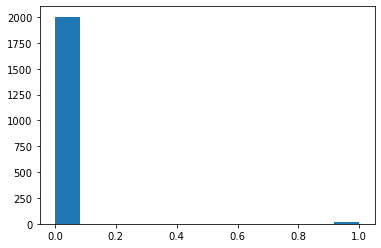

In [20]:
plt.hist(df['Complain'],bins="auto");

## Exploring data (Products)

Text(0, 0.5, 'freq')

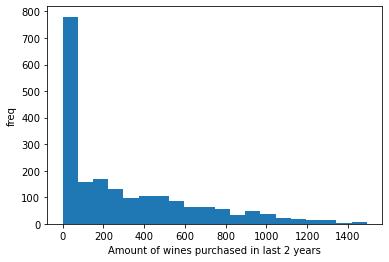

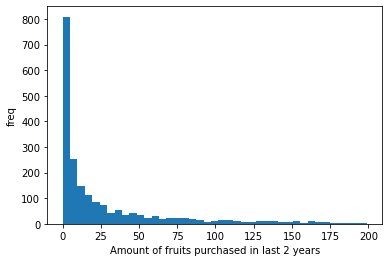

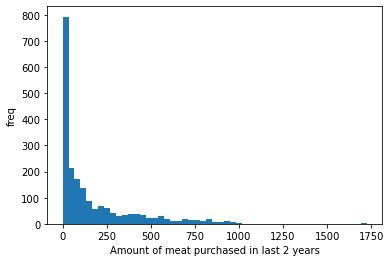

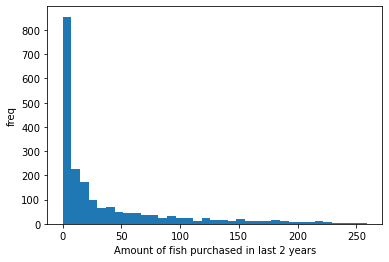

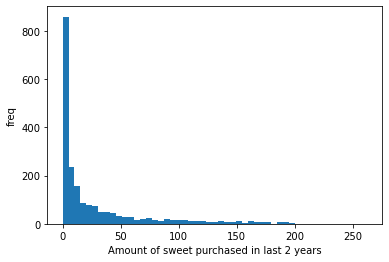

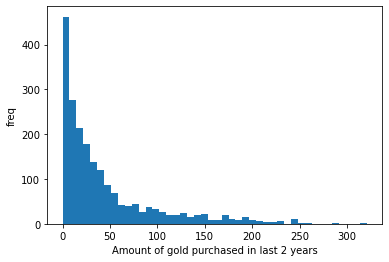

In [21]:
plt.figure(1)
plt.hist(df['MntWines'],bins="auto");
plt.xlabel("Amount of wines purchased in last 2 years")
plt.ylabel("freq")

plt.figure(2)
plt.hist(df['MntFruits'],bins="auto");
plt.xlabel("Amount of fruits purchased in last 2 years")
plt.ylabel("freq")

plt.figure(3)
plt.hist(df['MntMeatProducts'],bins="auto");
plt.xlabel("Amount of meat purchased in last 2 years")
plt.ylabel("freq")

plt.figure(4)
plt.hist(df['MntFishProducts'],bins="auto");
plt.xlabel("Amount of fish purchased in last 2 years")
plt.ylabel("freq")

plt.figure(5)
plt.hist(df['MntSweetProducts'],bins="auto");
plt.xlabel("Amount of sweet purchased in last 2 years")
plt.ylabel("freq")

plt.figure(6)
plt.hist(df['MntGoldProds'],bins="auto");
plt.xlabel("Amount of gold purchased in last 2 years")
plt.ylabel("freq")

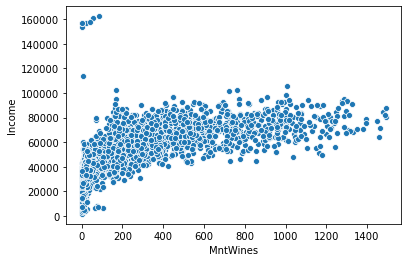

In [22]:
sns.scatterplot(x=df["MntWines"],y=df["Income"])
plt.savefig("winesincome.pdf")

{'whiskers': [<matplotlib.lines.Line2D at 0x223450c34c0>,
 'caps': [<matplotlib.lines.Line2D at 0x223450c3040>,
 'boxes': [<matplotlib.lines.Line2D at 0x223450c3f40>],
 'medians': [<matplotlib.lines.Line2D at 0x223450f6790>],
 'fliers': [<matplotlib.lines.Line2D at 0x223450f6250>],
 'means': []}

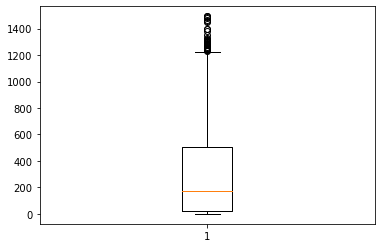

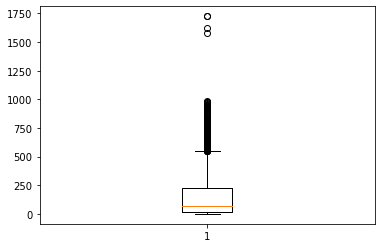

In [23]:
plt.figure(1)
plt.boxplot(df["MntWines"])
plt.figure(2)
plt.boxplot(df["MntMeatProducts"])

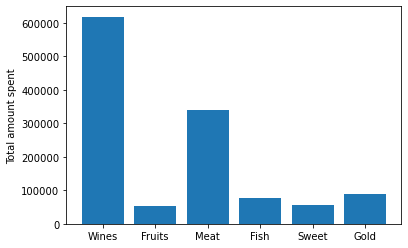

In [24]:
w = df['MntWines'].sum()
f = df['MntFruits'].sum()
m = df['MntMeatProducts'].sum()
fi = df['MntFishProducts'].sum()
s = df['MntSweetProducts'].sum()
g = df['MntGoldProds'].sum()
y = np.array([w,f,m,fi,s,g])
x = np.array(["Wines","Fruits","Meat","Fish","Sweet","Gold"])
plt.ylabel("Total amount spent")
plt.bar(x,y);
plt.savefig("totalMnt.pdf")

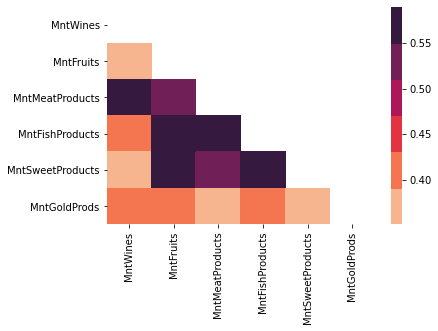

In [25]:
products = df[['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']]
corr = products.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

cmap = sns.color_palette("rocket_r")
sns.heatmap(corr, mask=mask, cmap=cmap)
plt.savefig("corrmap.pdf")

For each person we calculate the total amount spent for all products (it is a useful features)

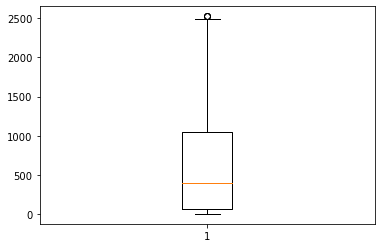

In [26]:
df["totalMnt"] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']
plt.boxplot(df["totalMnt"]);

## Exploring data (Purchases)

Text(0, 0.5, 'freq')

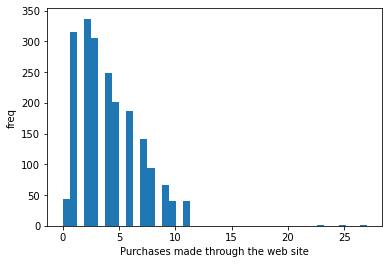

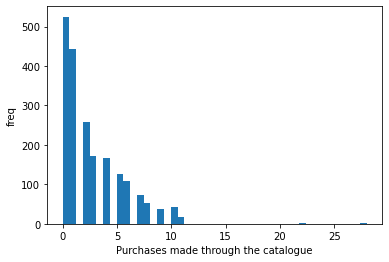

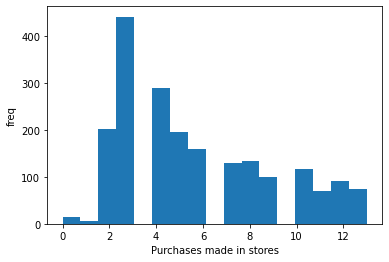

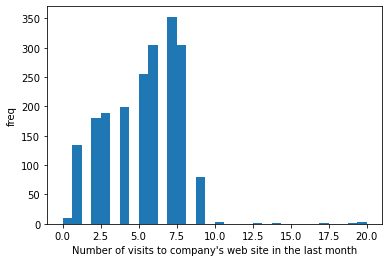

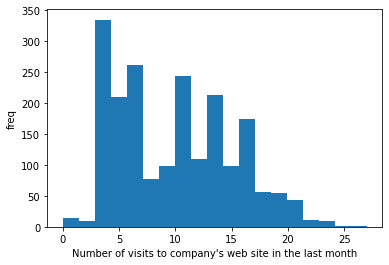

In [27]:
plt.figure(1)
plt.hist(df['NumWebPurchases'],bins="auto");
plt.xlabel("Purchases made through the web site")
plt.ylabel("freq")

plt.figure(2)
plt.hist(df['NumCatalogPurchases'],bins="auto");
plt.xlabel("Purchases made through the catalogue")
plt.ylabel("freq")

plt.figure(3)
plt.hist(df['NumStorePurchases'],bins="auto");
plt.xlabel("Purchases made in stores")
plt.ylabel("freq")

plt.figure(4)
plt.hist(df['NumWebVisitsMonth'],bins="auto");
plt.xlabel("Number of visits to company's web site in the last month")
plt.ylabel("freq")

plt.figure(5)
plt.hist((df['NumWebPurchases'].to_numpy()+df['NumStorePurchases'].to_numpy()),bins="auto");
plt.xlabel("Number of visits to company's web site in the last month")
plt.ylabel("freq")

<BarContainer object of 2 artists>

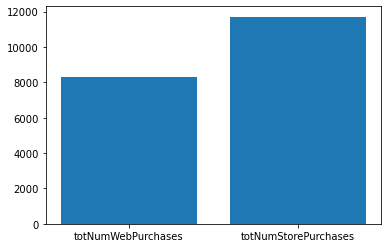

In [28]:
plt.bar(np.array(["totNumWebPurchases","totNumStorePurchases"]),np.array([df["NumWebPurchases"].sum(), df["NumStorePurchases"].sum()]))

## Correlation matrix

In [29]:
columns_to_scale = ["Income","Kidhome", "Teenhome", "Recency", "MntWines", "MntFruits",
                   "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds",
                   "NumDealsPurchases", "NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases", "NumWebVisitsMonth", "age"]
df_to_scale = df[columns_to_scale]

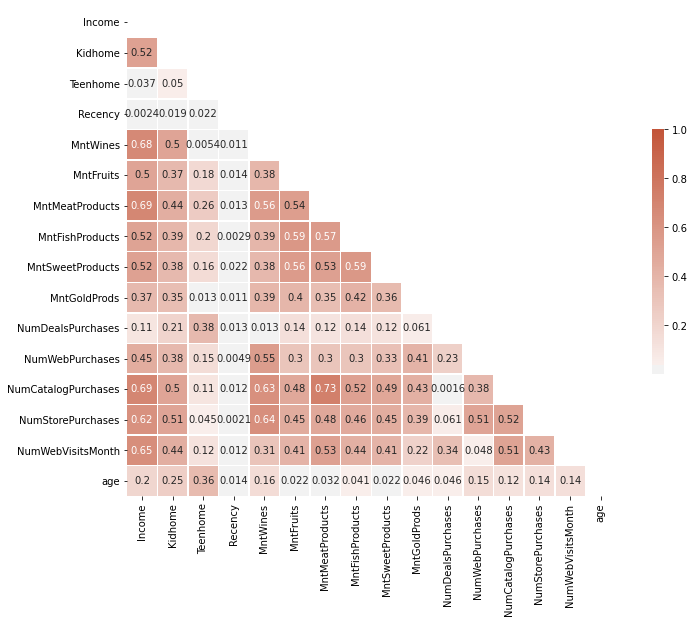

In [30]:
f, ax = plt.subplots(figsize=(13, 9))
sns.heatmap(df_to_scale.corr().abs(), cmap=sns.diverging_palette(230, 20, as_cmap=True), 
            mask = np.triu(np.ones_like(df_to_scale.corr(), dtype=bool)), vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.savefig("corrmap.pdf")

## Preprocessing Data

### Standard Scaler

In [31]:
""" 
INPUT: 
        - dataframe 
        - list of columns that I want to scale 
"""

""" 
OUTPUT:
        - standardized dataset 
        - scaler object 
"""
def standard_Scaler(df, l):
    scaler = StandardScaler()
    df_to_scale = df[l]
    df_scale = pd.DataFrame(scaler.fit_transform(df_to_scale), columns = l)
    return df_scale,scaler

## Models

In [32]:
""" PREPROCESSING """

""" apply the standard scaler only to the 3 columns (in order to do inverse_transformation) """

columns_to_scale = ["Income", "totalMnt", "age"]
df_scale_1, scaler_1 = standard_Scaler(df, columns_to_scale)

sse = []
for i in range(1,11):
    model = KMeans(n_clusters=i)
    model.fit_transform(df_scale_1)
    sse += [model.inertia_]

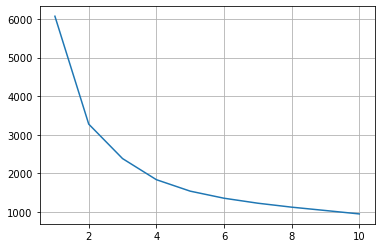

In [33]:
plt.grid()
plt.plot([1,2,3,4,5,6,7,8,9,10], sse)
plt.savefig("elbowcurve.pdf")

The best is to choose k=4, tradeoff between silhouette score and model complexity

In [34]:
k = 4

### k-means

In [35]:
""" k means """
# model = KMeans(n_clusters=k, init="random")

# model.fit_transform(df_scale_1)
# labels = model.predict(df_scale_1)

# df_original = pd.DataFrame(scaler_1.inverse_transform(df_scale_1)).rename(columns={0: 'Income', 1: 'totalMnt', 2: 'age'})
# df_labels = df_original
# df_labels["Label"] = labels

# df["Label"] = labels

' k means '

### k-means ++

In [36]:
""" k means ++ """
model = KMeans(n_clusters=k, init="k-means++")

model.fit_transform(df_scale_1)
labels = model.predict(df_scale_1)

df_original = pd.DataFrame(scaler_1.inverse_transform(df_scale_1)).rename(columns={0: 'Income', 1: 'totalMnt', 2: 'age'})
df_labels = df_original
df_labels["Label"] = labels

df["Label"] = labels

# df_labels.head()

df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,age,Children,Has_child,totalMnt,Label
0,Postgraduate,single,58138.0,0,0,58,635,88,546,172,...,0,0,3,11,1,55,0,No child,1617,1
1,Postgraduate,single,46344.0,1,1,38,11,1,6,2,...,0,0,3,11,0,60,2,Has child,27,2
2,Postgraduate,couple,71613.0,0,0,26,426,49,127,111,...,0,0,3,11,0,48,0,No child,776,1
3,Postgraduate,couple,26646.0,1,0,26,11,4,20,10,...,0,0,3,11,0,30,1,Has child,53,0
4,Postgraduate,couple,58293.0,1,0,94,173,43,118,46,...,0,0,3,11,0,33,1,Has child,422,0


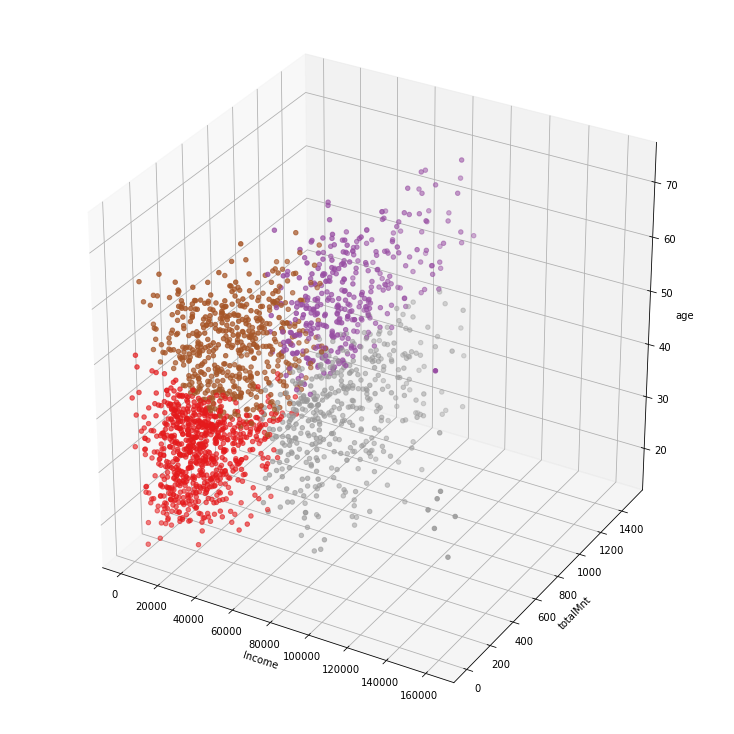

In [37]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

cmap = "Set1"
fig = plt.figure(figsize=(10,10))

ax = Axes3D(fig)

x = df["Income"]
y = df["MntWines"]
z = df["age"]
color = df['Label']

ax.scatter(x, y, z, c=color, marker='o', cmap=cmap)
ax.set_xlabel('Income')
ax.set_ylabel('totalMnt')
ax.set_zlabel('age')


plt.show()
fig.savefig("clusters.pdf")

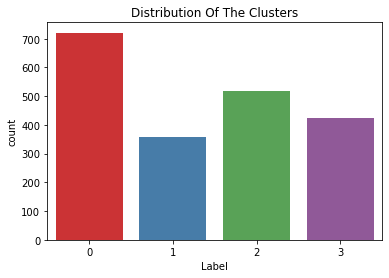

In [38]:
pl = sns.countplot(x=df["Label"], palette="Set1")
pl.set_title("Distribution Of The Clusters")
plt.show()

Now, we analyse in more details the clusterings results.

35.438280166435504 33231.565880721224 141.82385575589458


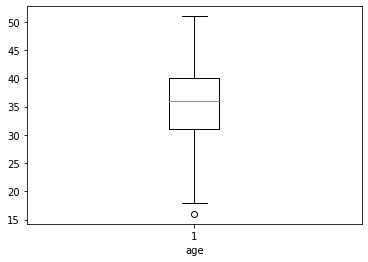

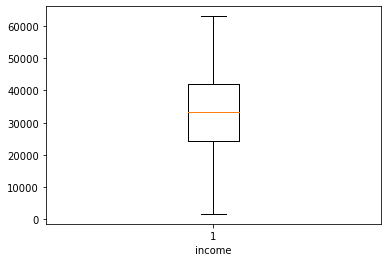

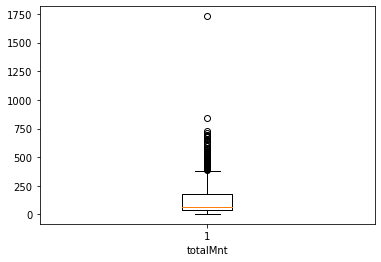

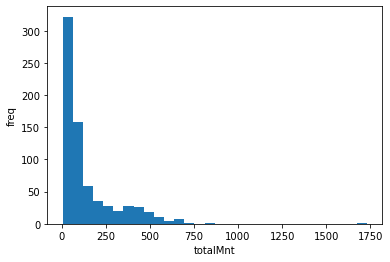

In [39]:
""" label: 0 """

mask = df['Label'] == 0
d = df[mask]
d.head()

plt.figure(1)
plt.boxplot(d["age"]);
plt.xlabel("age")

plt.figure(2)
plt.boxplot(d["Income"]);
plt.xlabel("income")

plt.figure(3)
plt.boxplot(d["totalMnt"]);
plt.xlabel("totalMnt")

plt.figure(4)
plt.hist(d["totalMnt"],bins=30);
plt.xlabel("totalMnt")
plt.ylabel("freq");
print(d["age"].mean(), d["Income"].mean(), d["totalMnt"].mean())

56.84357541899441 72761.62569832402 1251.167597765363


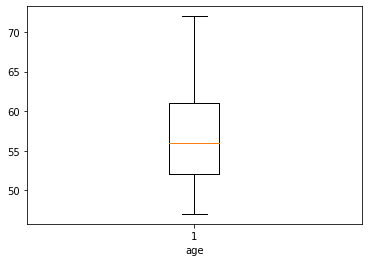

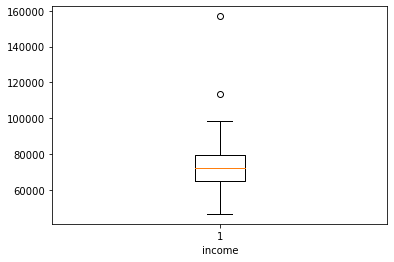

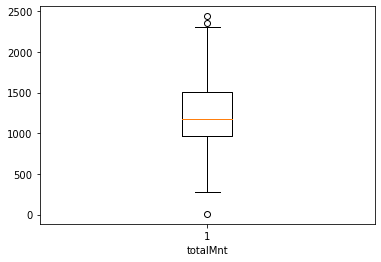

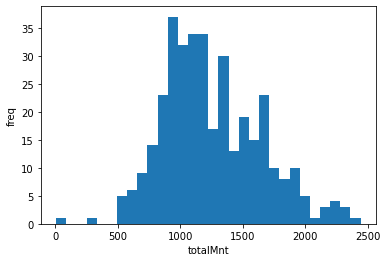

In [40]:
""" label: 1 """

mask = df['Label'] == 1
d = df[mask]
d.head()

plt.figure(1)
plt.boxplot(d["age"]);
plt.xlabel("age")

plt.figure(2)
plt.boxplot(d["Income"]);
plt.xlabel("income")

plt.figure(3)
plt.boxplot(d["totalMnt"]);
plt.xlabel("totalMnt")

plt.figure(4)
plt.hist(d["totalMnt"],bins=30);
plt.xlabel("totalMnt")
plt.ylabel("freq");
print(d["age"].mean(), d["Income"].mean(), d["totalMnt"].mean())

54.0616570327553 46119.63005780347 275.9942196531792


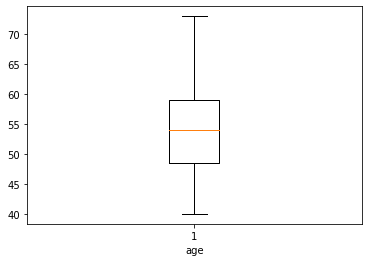

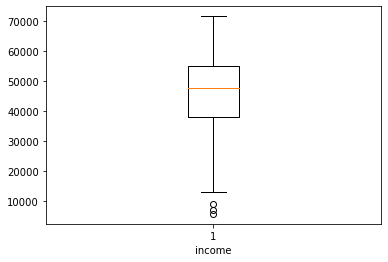

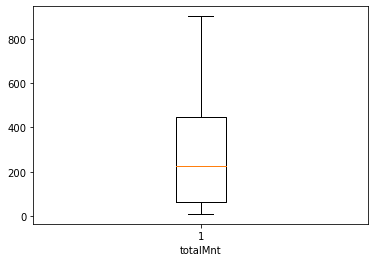

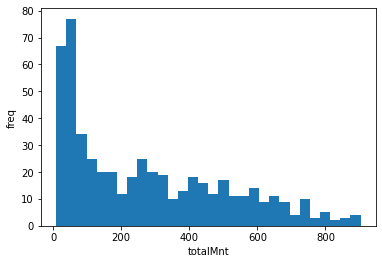

In [41]:
""" label: 2 """

mask = df['Label'] == 2
d = df[mask]
d.head()

plt.figure(1)
plt.boxplot(d["age"]);
plt.xlabel("age")

plt.figure(2)
plt.boxplot(d["Income"]);
plt.xlabel("income")

plt.figure(3)
plt.boxplot(d["totalMnt"]);
plt.xlabel("totalMnt")

plt.figure(4)
plt.hist(d["totalMnt"],bins=30);
plt.xlabel("totalMnt")
plt.ylabel("freq");

print(d["age"].mean(), d["Income"].mean(), d["totalMnt"].mean())

36.101176470588236 73720.13411764706 1262.3882352941177


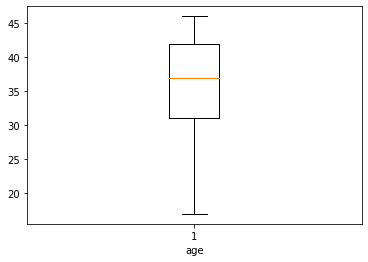

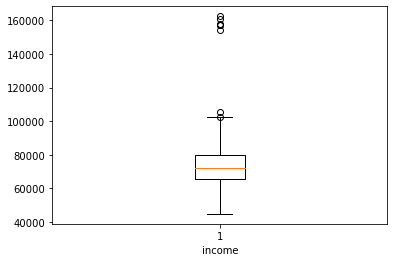

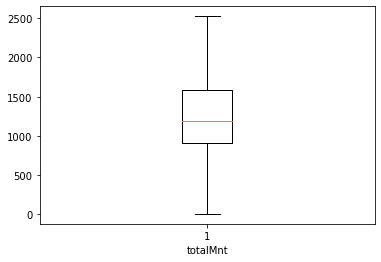

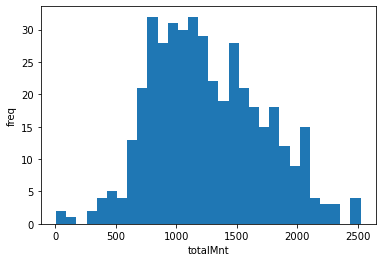

In [42]:
""" label: 3 """

mask = df['Label'] == 3
d = df[mask]
d.head()

plt.figure(1)
plt.boxplot(d["age"]);
plt.xlabel("age")

plt.figure(2)
plt.boxplot(d["Income"]);
plt.xlabel("income")

plt.figure(3)
plt.boxplot(d["totalMnt"]);
plt.xlabel("totalMnt")

plt.figure(4)
plt.hist(d["totalMnt"],bins=30);
plt.xlabel("totalMnt")
plt.ylabel("freq");

print(d["age"].mean(), d["Income"].mean(), d["totalMnt"].mean())

From this analysis we can conclude that we have 4 type of customers.
The groups of customers who deserve our attention are the one with label 1 and 3. They're high spending customers and they have an high income. Let's analyse better how this groups are composed and what are they purchasing habits.

In [43]:
mask = df['Label'] == 1
d1 = df[mask]

mask = df['Label'] == 2
d2 = df[mask]

mask = df['Label'] == 3
d3 = df[mask]

### Education, marital status and has child analysis

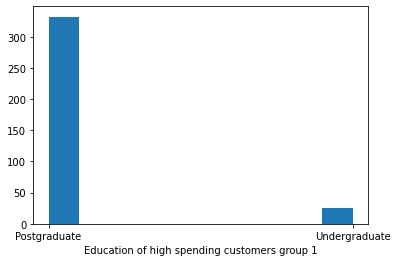

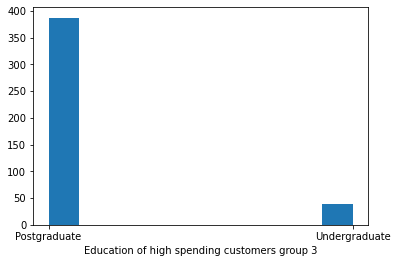

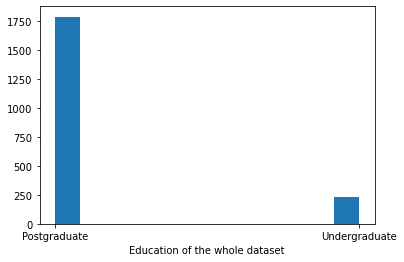

In [44]:
plt.figure(1)
plt.hist(d1["Education"],bins="auto");
plt.xlabel("Education of high spending customers group 1");

plt.figure(2)
plt.hist(d3["Education"],bins="auto");
plt.xlabel("Education of high spending customers group 3");

plt.figure(3)
plt.hist(df['Education'],bins="auto");
plt.xlabel("Education of the whole dataset");


The histogram suggests that the high spending customers are almost Postgraduate, but this due to the fact the Undergraduate are a minority in the dataset, so no useful information from this graph.


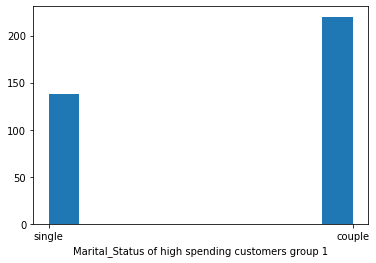

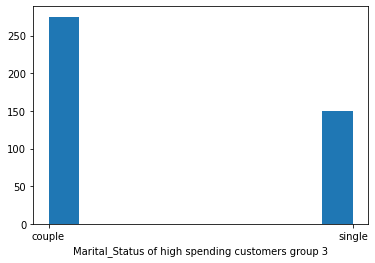

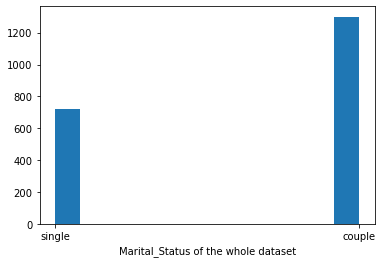

In [45]:
plt.figure(1)
plt.hist(d1["Marital_Status"],bins="auto");
plt.xlabel("Marital_Status of high spending customers group 1");

plt.figure(2)
plt.hist(d3["Marital_Status"],bins="auto");
plt.xlabel("Marital_Status of high spending customers group 3");

plt.figure(3)
plt.hist(df['Marital_Status'],bins="auto");
plt.xlabel("Marital_Status of the whole dataset");

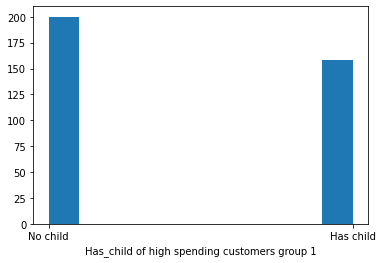

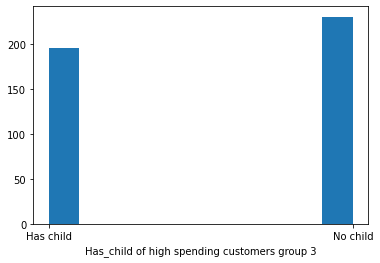

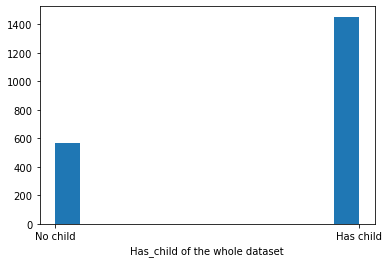

In [46]:
plt.figure(1)
plt.hist(d1["Has_child"],bins="auto");
plt.xlabel("Has_child of high spending customers group 1");

plt.figure(2)
plt.hist(d3["Has_child"],bins="auto");
plt.xlabel("Has_child of high spending customers group 3");

plt.figure(3)
plt.hist(df['Has_child'],bins="auto");
plt.xlabel("Has_child of the whole dataset");

In [47]:
totNochild = df[df["Has_child"] == "No child"].shape[0]
totNochild1 = d1[d1["Has_child"] == "No child"].shape[0]
totNochild3= d3[d3["Has_child"] == "No child"].shape[0]
totNochild, totNochild1, totNochild3

(569, 200, 230)

**RESULTS**

From this graphs we discover something really interesting: the total number of customers who have no child is 569. In the group 1 and group 3 (high spending customers) the number of customers who have no child is 430, around 76%. We can conlude that the majority of high spending customers have no child.

About education and marital status we cannot say anything because the high spending customers reflect the same distribution as in the dataset. We have no majority among those groups.

### Analysis of high spending customers (type of products)

In [48]:
w = d1['MntWines'].sum()
f = d1['MntFruits'].sum()
m = d1['MntMeatProducts'].sum()
fi = d1['MntFishProducts'].sum()
s = d1['MntSweetProducts'].sum()
g = d1['MntGoldProds'].sum()

w1 = d3['MntWines'].sum()
f1 = d3['MntFruits'].sum()
m1 = d3['MntMeatProducts'].sum()
fi1 = d3['MntFishProducts'].sum()
s1 = d3['MntSweetProducts'].sum()
g1 = d3['MntGoldProds'].sum()

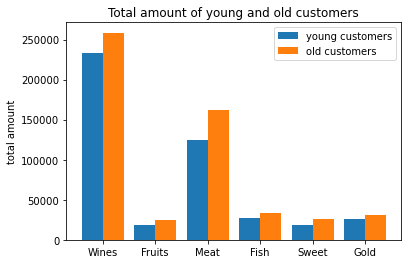

In [49]:
X = ['Wines','Fruits','Meat','Fish','Sweet','Gold']
group1 = [w,f,m,fi,s,g]
group3 = [w1,f1,m1,fi1,s1,g1]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, group1, 0.4, label = 'young customers')
plt.bar(X_axis + 0.2, group3, 0.4, label = 'old customers')
  
plt.xticks(X_axis, X)

plt.ylabel("total amount")
plt.title("Total amount of young and old customers")
plt.legend()
# plt.show()
plt.savefig("totMnt.pdf")

**RESULTS**

Among the two groups of high spending customers the purchasing patterns are pretty similar. One difference is that people from group 3 (older people) spend more on wines and meat than young people do.

### Analysis of high spending customers (types of purchases)

In [50]:
d1["totPurchases"] = d1["NumWebPurchases"] + d1["NumCatalogPurchases"] + d1["NumStorePurchases"]
d3["totPurchases"] = d3["NumWebPurchases"] + d3["NumCatalogPurchases"] + d3["NumStorePurchases"]

<ipython-input-50-27b7613a9553>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d1["totPurchases"] = d1["NumWebPurchases"] + d1["NumCatalogPurchases"] + d1["NumStorePurchases"]
<ipython-input-50-27b7613a9553>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d3["totPurchases"] = d3["NumWebPurchases"] + d3["NumCatalogPurchases"] + d3["NumStorePurchases"]


#### Web purchases

In [51]:
(d1["NumWebPurchases"]/d1["totPurchases"]).mean(), (d3["NumWebPurchases"]/d3["totPurchases"]).mean()

(0.2942662319484748, 0.28752827526009017)

**RESULTS**

The average percentage of web purchases among all purchases made by each group is really similar. The average percentage of web purchases  for group 1 is 28.8% and for the group 3 is 29.4. This means that older people are used to buy more online than young people (surprising!), however the difference between the two groups is not that much. 

#### catalog purchases

In [52]:
(d1["NumCatalogPurchases"]/d1["totPurchases"]).mean(), (d3["NumCatalogPurchases"]/d3["totPurchases"]).mean()

(0.27855293888639104, 0.26195898952961394)

**RESULTS** 

Same conclusion as the web purchases

#### store purchases

In [53]:
(d1["NumStorePurchases"]/d1["totPurchases"]).mean(), (d3["NumStorePurchases"]/d3["totPurchases"]).mean()

(0.4271808291651349, 0.45051273521029606)

**RESULTS**

The average percentage of store's purchases is slighlty higher for young people.

#### NumWebVisitMonths

The average of web visit per month for group 1 is :3.70


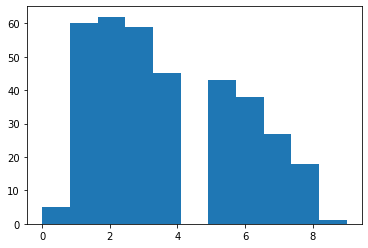

In [54]:
plt.hist(d1["NumWebVisitsMonth"], bins="auto");
avgWv = d1["NumWebVisitsMonth"].mean()
print(f"The average of web visit per month for group 1 is :{avgWv:.2f}")

The average of web visit per month for group 3 is :3.74


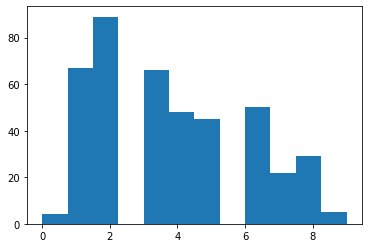

In [55]:
plt.hist(d3["NumWebVisitsMonth"], bins="auto");
avgWv = d3["NumWebVisitsMonth"].mean()
print(f"The average of web visit per month for group 3 is :{avgWv:.2f}")

### Need attention customers and main differences with high-spending customers

#### education, marital status, has child

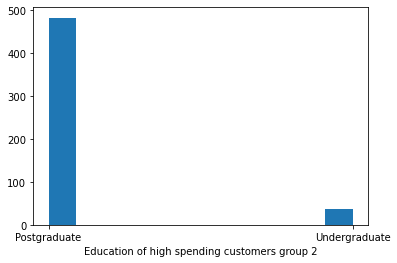

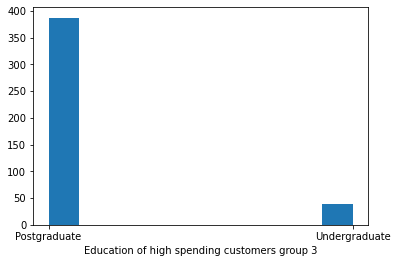

In [56]:
""" education """
plt.figure(1)
plt.hist(d2["Education"],bins="auto");
plt.xlabel("Education of high spending customers group 2");

plt.figure(2)
plt.hist(d3["Education"],bins="auto");
plt.xlabel("Education of high spending customers group 3");

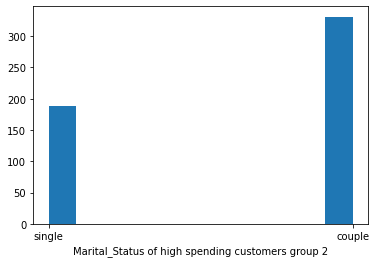

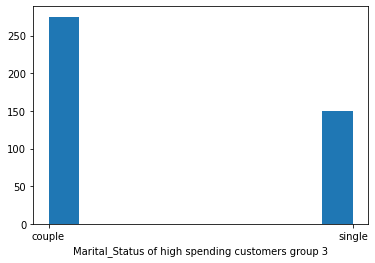

In [57]:
""" marital status """
plt.figure(1)
plt.hist(d2["Marital_Status"],bins="auto");
plt.xlabel("Marital_Status of high spending customers group 2");

plt.figure(2)
plt.hist(d3["Marital_Status"],bins="auto");
plt.xlabel("Marital_Status of high spending customers group 3");

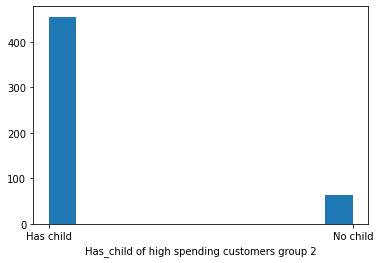

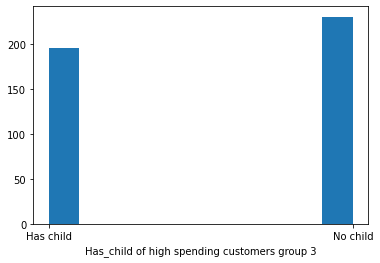

In [58]:
""" has child """
plt.figure(1)
plt.hist(d2["Has_child"],bins="auto");
plt.xlabel("Has_child of high spending customers group 2");

plt.figure(2)
plt.hist(d3["Has_child"],bins="auto");
plt.xlabel("Has_child of high spending customers group 3");

In [59]:
child2 = d2[d2["Has_child"] == "Has child"].shape[0]
nochild2 = d2[d2["Has_child"] == "No child"].shape[0]

child3 = d3[d3["Has_child"] == "Has child"].shape[0]
nochild3 = d3[d3["Has_child"] == "No child"].shape[0]
child2, nochild2, child3, nochild3

(455, 64, 195, 230)

**RESULTS**

The first main difference among these two groups is the fact they have children or not. 

These are the statistics for the group 2:
- total customers >= 1 child: 455
- total customers with no child: 64

These are the statistics for the group 3:
- total customers >= 1 child: 158
- total customers with no child: 200

We can conclude that having a child is a factor that has a strong infulence on the total amount of purchases spent: people with one child or more tend to spend less than people with no child.

### Analysis type of products

We focus our analysis on the spending habits of two different type of customers: medium-spending customers and low-spending customers.

**GOAL**: try to understand what different group of customers buy most.

We calculate, for each products, the percentage of the amount spent for that product over the total amount spent.

In [60]:
d2["%Wines"] = d2["MntWines"] / d2["totalMnt"]
d2["%Fruits"] = d2["MntFruits"] / d2["totalMnt"]
d2["%Meat"] = d2["MntMeatProducts"] / d2["totalMnt"]
d2["%Fish"] = d2["MntFishProducts"] / d2["totalMnt"]
d2["%Sweet"] = d2["MntSweetProducts"] / d2["totalMnt"]
d2["%Gold"] = d2["MntGoldProds"] / d2["totalMnt"]

<ipython-input-60-0b6165458d9b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d2["%Wines"] = d2["MntWines"] / d2["totalMnt"]
<ipython-input-60-0b6165458d9b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d2["%Fruits"] = d2["MntFruits"] / d2["totalMnt"]
<ipython-input-60-0b6165458d9b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [61]:
d3["%Wines"] = d3["MntWines"] / d3["totalMnt"]
d3["%Fruits"] = d3["MntFruits"] / d3["totalMnt"]
d3["%Meat"] = d3["MntMeatProducts"] / d3["totalMnt"]
d3["%Fish"] = d3["MntFishProducts"] / d3["totalMnt"]
d3["%Sweet"] = d3["MntSweetProducts"] / d3["totalMnt"]
d3["%Gold"] = d3["MntGoldProds"] / d3["totalMnt"]

<ipython-input-61-b6b916727484>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d3["%Wines"] = d3["MntWines"] / d3["totalMnt"]
<ipython-input-61-b6b916727484>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d3["%Fruits"] = d3["MntFruits"] / d3["totalMnt"]
<ipython-input-61-b6b916727484>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [62]:
d2.describe()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,age,Children,totalMnt,Label,%Wines,%Fruits,%Meat,%Fish,%Sweet,%Gold
count,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,...,519.000000,519.000000,519.000000,519.0,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000
mean,46119.630058,0.447013,0.901734,49.163776,161.868979,10.025048,51.539499,13.512524,9.942197,29.105973,...,54.061657,1.348748,275.994220,2.0,0.556026,0.037986,0.198508,0.050464,0.038241,0.118776
std,12122.969567,0.563176,0.421407,29.175447,161.017500,19.123086,53.916154,22.782829,18.928450,37.804751,...,6.555970,0.763396,233.070229,0.0,0.221051,0.053587,0.100200,0.066474,0.058608,0.097075
min,5648.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,40.000000,0.000000,9.000000,2.0,0.000000,0.000000,0.025751,0.000000,0.000000,0.000000
25%,37809.500000,0.000000,1.000000,24.000000,29.500000,0.000000,12.000000,0.000000,0.000000,5.000000,...,48.500000,1.000000,62.500000,2.0,0.400000,0.000000,0.121325,0.000000,0.000000,0.045973
50%,47743.000000,0.000000,1.000000,50.000000,107.000000,3.000000,30.000000,4.000000,3.000000,15.000000,...,54.000000,1.000000,227.000000,2.0,0.576271,0.016611,0.187302,0.025300,0.017279,0.090909
75%,54778.000000,1.000000,1.000000,74.000000,242.500000,11.000000,76.000000,16.000000,10.000000,38.000000,...,59.000000,2.000000,447.000000,2.0,0.728781,0.049510,0.266667,0.073082,0.050000,0.166667
max,71488.000000,2.000000,2.000000,99.000000,714.000000,151.000000,300.000000,153.000000,157.000000,229.000000,...,73.000000,3.000000,903.000000,2.0,0.932735,0.296296,0.526829,0.473186,0.600000,0.465116


In [63]:
d3.describe()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,Children,totalMnt,Label,totPurchases,%Wines,%Fruits,%Meat,%Fish,%Sweet,%Gold
count,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,...,425.000000,425.000000,425.0,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000
mean,73720.134118,0.141176,0.397647,49.357647,608.355294,57.028235,382.557647,80.148235,60.244706,74.054118,...,0.538824,1262.388235,3.0,19.428235,0.485159,0.047522,0.286408,0.065979,0.050192,0.064741
std,14749.779836,0.361892,0.527091,29.162914,310.951315,49.587964,269.766124,67.477069,52.321632,58.365709,...,0.647217,460.426865,0.0,4.513622,0.188702,0.043136,0.144817,0.056819,0.044802,0.052511
min,44802.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,6.000000,3.0,0.000000,0.000578,0.000000,0.038071,0.000000,0.000000,0.000000
25%,65295.000000,0.000000,0.000000,25.000000,371.000000,19.000000,158.000000,25.000000,19.000000,30.000000,...,0.000000,913.000000,3.0,17.000000,0.343126,0.017789,0.170879,0.024096,0.017478,0.024707
50%,72063.000000,0.000000,0.000000,49.000000,576.000000,42.000000,314.000000,63.000000,44.000000,55.000000,...,0.000000,1192.000000,3.0,19.000000,0.474841,0.035540,0.274252,0.050174,0.037353,0.047500
75%,80134.000000,0.000000,1.000000,73.000000,812.000000,86.000000,546.000000,120.000000,92.000000,106.000000,...,1.000000,1581.000000,3.0,22.000000,0.626158,0.067658,0.376495,0.096095,0.074653,0.090628
max,162397.000000,2.000000,2.000000,99.000000,1486.000000,199.000000,1725.000000,258.000000,198.000000,247.000000,...,3.000000,2525.000000,3.0,32.000000,0.933164,0.239669,0.997110,0.313487,0.226744,0.301102


**RESULTS**

The results are a bit surprising. Here the main differences:
- 55.6% of the total spent (low-spending customers) is for Wines, for the high-spending customers is 51.6%. Obviously the total amount spent in wine is higher for high-customers but in proportion low-spending customers buy more wine.
- Low-spending customers spent 11.9% for gold products while high-spending customers only 5.9%.  
- another difference is the meat consumption: low-spending customers spend 19.8% for meat products while high-spending customers 27.3%. High-spending customers consume more meat!

### Analysis type of purchases

We calculate the total number of purchases in order to analyse customers' habits.

In [64]:
d2["totPurchases"] = d2["NumWebPurchases"] + d2["NumCatalogPurchases"] + d2["NumStorePurchases"]
d3["totPurchases"] = d3["NumWebPurchases"] + d3["NumCatalogPurchases"] + d3["NumStorePurchases"]

<ipython-input-64-398877b6edee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d2["totPurchases"] = d2["NumWebPurchases"] + d2["NumCatalogPurchases"] + d2["NumStorePurchases"]
<ipython-input-64-398877b6edee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d3["totPurchases"] = d3["NumWebPurchases"] + d3["NumCatalogPurchases"] + d3["NumStorePurchases"]


In [65]:
(d2["NumWebPurchases"]/d2["totPurchases"]).mean(), (d3["NumWebPurchases"]/d3["totPurchases"]).mean()

(0.3499170165379749, 0.28752827526009017)

In [66]:
(d2["NumStorePurchases"]/d2["totPurchases"]).mean(), (d3["NumStorePurchases"]/d3["totPurchases"]).mean()

(0.5311898187692318, 0.45051273521029606)

In [67]:
(d2["NumCatalogPurchases"]/d2["totPurchases"]).mean(), (d3["NumCatalogPurchases"]/d3["totPurchases"]).mean()

(0.11889316469279446, 0.26195898952961394)

In [68]:
(d2["NumDealsPurchases"]/d2["totPurchases"]).mean(), (d3["NumDealsPurchases"]/d3["totPurchases"]).mean()

(0.30210431359633266, 0.10853728538080085)

**RESULTS**

A catalogue is a book or magazine containing details and pictures of items currently being offered for sale, especially as used by companies that do much of their business by mail order



Lots of useful information from this analysis:
- "NumDealsPurhcases": 30.2% for customers of group 2 and only 10.5% for customers of group 3. Customers with high-spending nature are less concerned about deals than medium-spending customers. (an idea to increase the purhcases for group 2 could be to make more discount campaigns)
- "NumCatalogPurchases": 11.9% for customers of group 2 and 27.9% for customers of group 3. 
- customers with medium-spending nature use more the web and store to buy products, while high-spending customers use more catalog.

## Association rule

In [82]:
#d1 and d3 potential customers

df_interested = pd.concat([d1,d3])

# creating dataframe for using association rule algorithms 
df_fp = pd.DataFrame()
df_fp["Wines"] = pd.qcut(df_interested["MntWines"], 2, labels=["low","high"]) #175 middle value
df_fp["Fruits"] = pd.qcut(df_interested["MntFruits"], 2, labels=["low","high"])#8 middle value
df_fp["Meat"] = pd.qcut(df_interested["MntMeatProducts"], 2, labels=["low","high"]) #68 middle value
df_fp["Fish"] = pd.qcut(df_interested["MntFishProducts"], 2, labels=["low","high"]) #12 middle value
df_fp["Sweet"] = pd.qcut(df_interested["MntSweetProducts"], 2, labels=["low","high"]) #8 middle value
df_fp["age"] = pd.qcut(df_interested["age"], 2, labels=[">=40 <=55",">55"]) 
df_fp[" "] = df_interested["Has_child"]
df_fp["Education"] = df_interested["Education"]
df_fp = pd.get_dummies(df_fp)

In [78]:
'''
Filtering only consequents with Wines_high
'''
#Apriori min support
min_support = 0.05

#Max lenght of apriori n-grams
max_len = 2

frequent_items = fpgrowth(df_fp, use_colnames=True, min_support=min_support, max_len=max_len + 1)
rules = association_rules(frequent_items, metric='lift', min_threshold=1.5)

target = '{\'Wines_high\'}'

results_wine = rules[(rules['consequents'].astype(str).str.contains(target, na=False)) & (rules["confidence"]>0.80)].sort_values(by='confidence', ascending=False)

#print(results_wine[["antecedents", "consequents", "confidence", "lift"]].to_latex(index=False))
results_wine

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


In [71]:
'''
Filtering only consequents with MntFruits_high
'''
#Apriori min support
min_support = 0.05

#Max lenght of apriori n-grams
max_len = 2

frequent_items = fpgrowth(df_fp, use_colnames=True, min_support=min_support, max_len=max_len + 1)
rules = association_rules(frequent_items, metric='lift', min_threshold=1.5)

target = '{\'Fruits_high\'}'

results_fruits = rules[(rules['consequents'].astype(str).str.contains(target, na=False)) & (rules["confidence"]>0.80)].sort_values(by='confidence', ascending=False)

#print(results_fruits[["antecedents", "consequents", "confidence", "lift"]].to_latex(index=False))
results_fruits

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


In [72]:
'''
Filtering only consequents with MntMeatProducts_high
'''
#Fpgrowth min support
min_support = 0.05

#Max lenght of apriori n-grams
max_len = 2

frequent_items = fpgrowth(df_fp, use_colnames=True, min_support=min_support, max_len=max_len + 1)
rules = association_rules(frequent_items, metric='lift', min_threshold=1.5)

target = '{\'Meat_high\'}'

results_meat = rules[(rules['consequents'].astype(str).str.contains(target, na=False)) & (rules["confidence"]>0.80)].sort_values(by='confidence', ascending=False)


#print(results_meat[["antecedents", "consequents", "confidence", "lift"]].to_latex(index=False))
results_meat

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
3,"(Fish_high, _No child)",(Meat_high),0.323116,0.49553,0.259259,0.802372,1.619219,0.099145,2.552618


In [73]:
'''
Filtering only consequents with MntFishProducts_high
'''
#Apriori min support
min_support = 0.05

#Max lenght of apriori n-grams
max_len = 2

frequent_items = fpgrowth(df_fp, use_colnames=True, min_support=min_support, max_len=max_len + 1)
rules = association_rules(frequent_items, metric='lift', min_threshold=1.5)

target = '{\'Fish_high\'}'

results_fish = rules[(rules['consequents'].astype(str).str.contains(target, na=False)) & (rules["confidence"]>0.80)].sort_values(by='confidence', ascending=False)

#print(results_fish[["antecedents", "consequents", "confidence", "lift"]].to_latex(index=False))
results_fish

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


In [74]:
'''
Filtering only consequents with MntSweetProducts_high
'''
#Apriori min support
min_support = 0.05

#Max lenght of apriori n-grams
max_len = 2

frequent_items = fpgrowth(df_fp, use_colnames=True, min_support=min_support, max_len=max_len + 1)
rules = association_rules(frequent_items, metric='lift', min_threshold=1.5)

target = '{\'Sweet_high\'}'

results_sweet = rules[(rules['consequents'].astype(str).str.contains(target, na=False)) & (rules["confidence"]>0.80)].sort_values(by='confidence', ascending=False)

#print(results_sweet[["antecedents", "consequents", "confidence", "lift"]].to_latex(index=False))
results_sweet

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
